# UR-CarA-Net: A cascaded framework with uncertainty regularization for automated segmentation of carotid arteries on black blood MR images  
  
E. Lavrova, 2023  
  
This is the code supporting the corresponding paper and performing EVALUATION of the models.
  
Packages import:

In [96]:
import seg_metrics.seg_metrics as sg
import pandas as pd
import numpy as np
import nibabel as nib
import os
import pydicom
from skimage import morphology
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
import cv2
from skimage.morphology import skeletonize, skeletonize_3d
import pickle
from sklearn.metrics import brier_score_loss
from scipy.stats import gaussian_kde
from matplotlib.patches import Rectangle
from skimage import morphology
import glob
from sklearn.metrics import r2_score
import scipy
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import seaborn as sns
from scipy import stats
from scipy import ndimage
import numpy as np
import SimpleITK as sitk
from sklearn.metrics import mean_squared_error
import math
from skimage import morphology
import skimage

# for Hausdorff distance (data source: https://github.com/deepmind/surface-distance)
import lookup_tables

## 1. Models performance

Scores (see the corresponding paper for more description paper):

In [98]:
def icc(Y, icc_type='ICC(2,1)'):
    
    ''' Calculate intraclass correlation coefficient
    
    !!!!!!!
    SOURCE: https://github.com/cosanlab/nltools/tree/master/nltools
    !!!!!!!

    ICC Formulas are based on:
    Shrout, P. E., & Fleiss, J. L. (1979). Intraclass correlations: uses in
    assessing rater reliability. Psychological bulletin, 86(2), 420.
    icc1:  x_ij = mu + beta_j + w_ij
    icc2/3:  x_ij = mu + alpha_i + beta_j + (ab)_ij + epsilon_ij
    Code modifed from nipype algorithms.icc
    https://github.com/nipy/nipype/blob/master/nipype/algorithms/icc.py

    Args:
        Y: The data Y are entered as a 'table' ie. subjects are in rows and repeated
            measures in columns
        icc_type: type of ICC to calculate. (ICC(2,1), ICC(2,k), ICC(3,1), ICC(3,k)) 
    Returns:
        ICC: (np.array) intraclass correlation coefficient
    '''

    [n, k] = Y.shape

    # Degrees of Freedom
    dfc = k - 1
    dfe = (n - 1) * (k-1)
    dfr = n - 1

    # Sum Square Total
    mean_Y = np.mean(Y)
    SST = ((Y - mean_Y) ** 2).sum()

    # create the design matrix for the different levels
    x = np.kron(np.eye(k), np.ones((n, 1)))  # sessions
    x0 = np.tile(np.eye(n), (k, 1))  # subjects
    X = np.hstack([x, x0])

    # Sum Square Error
    predicted_Y = np.dot(np.dot(np.dot(X, np.linalg.pinv(np.dot(X.T, X))),
                                X.T), Y.flatten('F'))
    residuals = Y.flatten('F') - predicted_Y
    SSE = (residuals ** 2).sum()

    MSE = SSE / dfe

    # Sum square column effect - between colums
    SSC = ((np.mean(Y, 0) - mean_Y) ** 2).sum() * n
    MSC = SSC / dfc  # / n (without n in SPSS results)

    # Sum Square subject effect - between rows/subjects
    SSR = SST - SSC - SSE
    MSR = SSR / dfr

    if icc_type == 'icc1':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        # ICC = (MSR - MSRW) / (MSR + (k-1) * MSRW)
        NotImplementedError("This method isn't implemented yet.")

    elif icc_type == 'ICC(2,1)' or icc_type == 'ICC(2,k)':
        # ICC(2,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error +
        # k*(mean square columns - mean square error)/n)
        if icc_type == 'ICC(2,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE + k * (MSC - MSE) / n)

    elif icc_type == 'ICC(3,1)' or icc_type == 'ICC(3,k)':
        # ICC(3,1) = (mean square subject - mean square error) /
        # (mean square subject + (k-1)*mean square error)
        if icc_type == 'ICC(3,k)':
            k = 1
        ICC = (MSR - MSE) / (MSR + (k-1) * MSE)

    return ICC

def cl_score(v, s):
    """[this function computes the skeleton volume overlap]
    Args:
        v ([bool]): [image]
        s ([bool]): [skeleton]
    Returns:
        [float]: [computed skeleton volume intersection]
    """
    return np.sum(v*s)/np.sum(s)


def clDice(v_l, v_p):
    """[this function computes the cldice metric]
    Args:
        v_p ([bool]): [predicted image]
        v_l ([bool]): [ground truth image]
    Returns:
        [float]: [cldice metric]
    """
    if len(v_p.shape)==2:
        tprec = cl_score(v_p,skeletonize(v_l))
        tsens = cl_score(v_l,skeletonize(v_p))
    elif len(v_p.shape)==3:
        tprec = cl_score(v_p,skeletonize_3d(v_l))
        tsens = cl_score(v_l,skeletonize_3d(v_p))
    return 2*tprec*tsens/(tprec+tsens)

def compute_dice_coef(y_true, y_pred):

    smooth=1
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_jaccard_coef(y_true, y_pred):

    smooth=1
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return intersection / union

def getEdgeOfMask(mask):
    
    edge = np.zeros_like(mask)
    mask_pixels = np.where(mask > 0)

    for idx in range(0,mask_pixels[0].size):

        x = mask_pixels[0][idx]
        y = mask_pixels[1][idx]
        z = mask_pixels[2][idx]

        if mask[x-1:x+2, y-1:y+2, z-1:z+2].sum() < 27:
            edge[x,y,z] = 1
            
    return edge

def compute_AddedPathLength(mask_true, mask_pred, spacing_mm):
    
    edge_true = getEdgeOfMask(mask_true)
    edge_pred = getEdgeOfMask(mask_pred)
   
    apl = (edge_true > edge_pred).astype(int).sum()/np.sum(np.sum(edge_true))
    
    return apl 

def compute_nsd(img_1, img_2, tau):
    
    img_1_b = getEdgeOfMask(img_1)
    img_2_b = getEdgeOfMask(img_2)
    
    strel_size = 1 + tau*2
    strel = np.ones((strel_size, strel_size, strel_size))
    
    img_1_bb = morphology.binary_dilation(img_1_b, strel)
    img_2_bb = morphology.binary_dilation(img_2_b, strel)
    
    int_1 = img_1_b*img_2_bb
    int_2 = img_1_bb*img_2_b
    
    return (np.sum(int_1)+np.sum(int_2))/(np.sum(img_1_b) + np.sum(img_2_b))

def get_mc(a, b):
    b = skimage.morphology.binary_dilation(b)
    b = skimage.morphology.binary_dilation(b)
    b = skimage.morphology.binary_dilation(b)
    ab = a*b/b
    ab_max = np.nanmax(ab)
    ab_min = np.nanmin(ab)
    return (ab_max-ab_min)/(ab_max+ab_min)

def compute_hausdorf_surf_distance(mask_gt, mask_pred, spacing_mm, percent=95):
    
    """
    !!!!!!!
    SOURCE: https://github.com/deepmind/surface-distance
    !!!!!!!
    
    Computes the robust Hausdorff distance. "Robust", because it uses the `percent` percentile 
    of the distances instead of the maximum distance. The percentage is computed by correctly taking 
    the area of each surface element into account.
    Args:
        mask_gt: 3-dim Numpy array of type bool. The ground truth mask.
        mask_pred: 3-dim Numpy array of type bool. The predicted mask.
        spacing_mm: 3-element list-like structure. Voxel spacing in x0, x1 and x2 direction.
        percent: a float value between 0 and 100.
    Returns:
        a float value. The robust Hausdorff distance in mm. If one of the masks
        is empty, the corresponding lists are empty and all distances in the other
        list are `inf`.
    """
    
    mask_gt = mask_gt>0
    mask_pred = mask_pred>0

    neighbour_code_to_surface_area = np.zeros([256])
    for code in range(256):
        normals = np.array(lookup_tables._NEIGHBOUR_CODE_TO_NORMALS[code])
        sum_area = 0
        for normal_idx in range(normals.shape[0]):
            # normal vector
            n = np.zeros([3])
            n[0] = normals[normal_idx, 0] * spacing_mm[1] * spacing_mm[2]
            n[1] = normals[normal_idx, 1] * spacing_mm[0] * spacing_mm[2]
            n[2] = normals[normal_idx, 2] * spacing_mm[0] * spacing_mm[1]
            area = np.linalg.norm(n)
            sum_area += area
        neighbour_code_to_surface_area[code] = sum_area

    # compute the bounding box of the masks to trim
    # the volume to the smallest possible processing subvolume
    mask_all = mask_gt | mask_pred
    bbox_min = np.zeros(3, np.int64)
    bbox_max = np.zeros(3, np.int64)

    # max projection to the x0-axis
    proj_0 = np.max(np.max(mask_all, axis=2), axis=1)
    idx_nonzero_0 = np.nonzero(proj_0)[0]
    if len(idx_nonzero_0) == 0:  # pylint: disable=g-explicit-length-test
        return {"distances_gt_to_pred": np.array([]),
                "distances_pred_to_gt": np.array([]),
                "surfel_areas_gt": np.array([]),
                "surfel_areas_pred": np.array([])}

    bbox_min[0] = np.min(idx_nonzero_0)
    bbox_max[0] = np.max(idx_nonzero_0)

    # max projection to the x1-axis
    proj_1 = np.max(np.max(mask_all, axis=2), axis=0)
    idx_nonzero_1 = np.nonzero(proj_1)[0]
    bbox_min[1] = np.min(idx_nonzero_1)
    bbox_max[1] = np.max(idx_nonzero_1)

    # max projection to the x2-axis
    proj_2 = np.max(np.max(mask_all, axis=1), axis=0)
    idx_nonzero_2 = np.nonzero(proj_2)[0]
    bbox_min[2] = np.min(idx_nonzero_2)
    bbox_max[2] = np.max(idx_nonzero_2)

    # crop the processing subvolume.
    # we need to zeropad the cropped region with 1 voxel at the lower,
    # the right and the back side. This is required to obtain the "full"
    # convolution result with the 2x2x2 kernel
    cropmask_gt = np.zeros((bbox_max - bbox_min)+2, np.uint8)
    cropmask_pred = np.zeros((bbox_max - bbox_min)+2, np.uint8)

    cropmask_gt[0:-1, 0:-1, 0:-1] = mask_gt[bbox_min[0]:bbox_max[0]+1,bbox_min[1]:bbox_max[1]+1,
                                          bbox_min[2]:bbox_max[2]+1]

    cropmask_pred[0:-1, 0:-1, 0:-1] = mask_pred[bbox_min[0]:bbox_max[0]+1,bbox_min[1]:bbox_max[1]+1,
                                              bbox_min[2]:bbox_max[2]+1]

    # compute the neighbour code (local binary pattern) for each voxel
    # the resultsing arrays are spacially shifted by minus half a voxel in each
    # axis.
    # i.e. the points are located at the corners of the original voxels
    kernel = np.array([[[128, 64],[32, 16]],[[8, 4],[2, 1]]])
    
    neighbour_code_map_gt = ndimage.filters.correlate(cropmask_gt.astype(np.uint8), kernel, mode="constant", cval=0)
    neighbour_code_map_pred = ndimage.filters.correlate(cropmask_pred.astype(np.uint8), kernel, mode="constant", cval=0)

    # create masks with the surface voxels
    borders_gt = ((neighbour_code_map_gt != 0) & (neighbour_code_map_gt != 255))
    borders_pred = ((neighbour_code_map_pred != 0) &(neighbour_code_map_pred != 255))

    # compute the distance transform (closest distance of each voxel to the surface voxels)
    if borders_gt.any():
        distmap_gt = ndimage.morphology.distance_transform_edt(~borders_gt, sampling=spacing_mm)
    else:
        distmap_gt = np.Inf * np.ones(borders_gt.shape)

    if borders_pred.any():
        distmap_pred = ndimage.morphology.distance_transform_edt(~borders_pred, sampling=spacing_mm)
    else:
        distmap_pred = np.Inf * np.ones(borders_pred.shape)

    # compute the area of each surface element
    surface_area_map_gt = neighbour_code_to_surface_area[neighbour_code_map_gt]
    surface_area_map_pred = neighbour_code_to_surface_area[neighbour_code_map_pred]

    # create a list of all surface elements with distance and area
    distances_gt_to_pred = distmap_pred[borders_gt]
    distances_pred_to_gt = distmap_gt[borders_pred]
    surfel_areas_gt = surface_area_map_gt[borders_gt]
    surfel_areas_pred = surface_area_map_pred[borders_pred]

    # sort them by distance
    if distances_gt_to_pred.shape != (0,):
        sorted_surfels_gt = np.array(sorted(zip(distances_gt_to_pred, surfel_areas_gt)))
        distances_gt_to_pred = sorted_surfels_gt[:, 0]
        surfel_areas_gt = sorted_surfels_gt[:, 1]

    if distances_pred_to_gt.shape != (0,):
        sorted_surfels_pred = np.array(sorted(zip(distances_pred_to_gt, surfel_areas_pred)))
        distances_pred_to_gt = sorted_surfels_pred[:, 0]
        surfel_areas_pred = sorted_surfels_pred[:, 1]

    if len(distances_gt_to_pred) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_gt = np.cumsum(surfel_areas_gt) / np.sum(surfel_areas_gt)
        idx = np.searchsorted(surfel_areas_cum_gt, percent/100.0)
        perc_distance_gt_to_pred = distances_gt_to_pred[min(idx, len(distances_gt_to_pred)-1)]
        max_distance_gt_to_pred = np.max(distances_gt_to_pred)
    else:
        perc_distance_gt_to_pred = np.Inf
        max_distance_gt_to_pred = np.Inf

    if len(distances_pred_to_gt) > 0:  # pylint: disable=g-explicit-length-test
        surfel_areas_cum_pred = (np.cumsum(surfel_areas_pred) /np.sum(surfel_areas_pred))
        idx = np.searchsorted(surfel_areas_cum_pred, percent/100.0)
        perc_distance_pred_to_gt = distances_pred_to_gt[min(idx, len(distances_pred_to_gt)-1)]
        max_distance_pred_to_gt = np.max(distances_pred_to_gt)
    else:
        perc_distance_pred_to_gt = np.Inf
        max_distance_pred_to_gt = np.Inf

    return max(max_distance_gt_to_pred, max_distance_pred_to_gt), max(perc_distance_gt_to_pred, perc_distance_pred_to_gt)

Test set names:

In [105]:
# DD, D1, and D2
sub_names_test = ['AMC012', 'AMC006', 
                  'MUMC094', 'MUMC027', 'MUMC079', 'MUMC052', 'MUMC127', 'MUMC071', 'MUMC038', 'MUMC093', 'MUMC107', 
                  'MUMC022', 'MUMC114', 'MUMC115', 'MUMC069', 'MUMC130', 'MUMC036', 'MUMC007', 'MUMC059', 'MUMC080', 
                  'UMCU036', 'UMCU025', 'UMCU008', 'UMCU034']
# ED
sub_names_emc = ['EMC003', 'EMC004', 'EMC005', 'EMC007', 'EMC008', 'EMC009', 'EMC011', 
                 'EMC015', 'EMC018', 'EMC020', 'EMC024', 'EMC027', 'EMC029', 'EMC031', 
                 'EMC032', 'EMC034', 'EMC035', 'EMC036', 'EMC038', 'EMC041', 'EMC042', 
                 'EMC043', 'EMC045', 'EMC046', 'EMC047', 'EMC048', 'EMC049', 'EMC050', 
                 'EMC051', 'EMC052', 'EMC054', 'EMC055', 'EMC056', 'EMC057']

GT and outputs location:

In [106]:
nifti_dirname_GT_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_GT"
nifti_dirname_GT_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_GT"
nifti_dirname_GT_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_GT"
nifti_dirname_GT_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_GT"

nifti_dirname_nnunet_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_nnunet"
nifti_dirname_nnunet_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_nnunet"
nifti_dirname_nnunet_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_nnunet"
nifti_dirname_nnunet_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_nnunet"

nifti_dirname_nnunet_test_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_nnunet_p"
nifti_dirname_nnunet_t2w_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_nnunet_p"
nifti_dirname_nnunet_t1wce_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_nnunet_p"
nifti_dirname_nnunet_emc_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_nnunet_p"

nifti_dirname_plaqunet_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_plaqunet"
nifti_dirname_plaqunet_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_plaqunet"
nifti_dirname_plaqunet_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_plaqunet"
nifti_dirname_plaqunet_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_plaqunet"

nifti_dirname_plaqunet_test_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_plaqunet_p"
nifti_dirname_plaqunet_t2w_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_plaqunet_p"
nifti_dirname_plaqunet_t1wce_sm=r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_plaqunet_p"
nifti_dirname_plaqunet_emc_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_plaqunet_p"

nifti_dirname_plaqumap_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_plaqumap"
nifti_dirname_plaqumap_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_plaqumap"
nifti_dirname_plaqumap_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_plaqumap"
nifti_dirname_plaqumap_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_plaqumap"

nifti_dirname_plaqumap_test_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_plaqumap_p"
nifti_dirname_plaqumap_t2w_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_plaqumap_p"
nifti_dirname_plaqumap_t1wce_sm=r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_plaqumap_p"
nifti_dirname_plaqumap_emc_sm = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_plaqumap_p"

nifti_dirname_img_test = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\test\test_img"
nifti_dirname_img_t1wce = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t1wce\t1wce_img"
nifti_dirname_img_t2w = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\t2w\t2w_img"
nifti_dirname_img_emc = r"C:\Users\E.Lavrova\Documents\GitHub\plaq-u-net\res\nifti_compare\emc\emc_img"

Score reporting:

In [128]:
def get_score_median_iqr(df_scores):
    median_scores = df_scores.median()
    iqr_scores = df_scores.quantile(0.75) - df_scores.quantile(0.25)
    return median_scores, iqr_scores

def get_scores_df(sub_names, dirname_gt, dirname_pred, dirname_img, mk_th):

    df_scores = []

    for sub_name in sub_names:

        filename_gt = os.path.join(dirname_gt, sub_name + '.nii.gz')
        filename_pred = os.path.join(dirname_pred, sub_name + '.nii.gz')
        filename_img = os.path.join(dirname_img, sub_name + '.nii.gz')

        mask_gt = sitk.ReadImage(filename_gt)
        mask_pred = sitk.ReadImage(filename_pred)
        img = sitk.ReadImage(filename_img)

        mask_gt = sitk.GetArrayFromImage(mask_gt)
        mask_pred = sitk.GetArrayFromImage(mask_pred)
        img = sitk.GetArrayFromImage(img)

        rec = {'sub': sub_name} 
        rec['DSC'] = compute_dice_coef(mask_gt, mask_pred)
        rec['JSC'] = compute_jaccard_coef(mask_gt, mask_pred)

        hd_max, hd_95 = compute_hausdorf_surf_distance(mask_gt, mask_pred, [2, 0.303030, 0.303030], percent=95)

        rec['HD'] = hd_max
        rec['HD95'] = hd_95

        rec['clDSC'] = clDice(mask_gt, mask_pred)
        rec['NSD'] = compute_nsd(mask_gt, mask_pred, tau=2)
        rec['APL'] = compute_AddedPathLength(mask_gt, mask_pred, [0.303030, 0.303030])
        
        vol_gt = np.sum(mask_gt)*0.303030*0.303030*2/1000
        vol_pred = np.sum(mask_pred)*0.303030*0.303030*2/1000

        rec['vol_gt, ml'] = vol_gt
        rec['vol_pred, ml'] = vol_pred

        rec['vol_diff, ml'] = vol_gt-vol_pred
        rec['abs_vol_diff, ml'] = abs(vol_gt-vol_pred)
        
        rec['MC'] = get_mc(img, mask_gt) 

        df_scores.append(rec)

    df_scores = pd.DataFrame(df_scores)
    
    median_scores, iqr_scores = get_score_median_iqr(df_scores)
    df_scores['mc_out'] = df_scores['MC']<mk_th

    return df_scores, median_scores, iqr_scores

### 1.1 nnU-Net

In [130]:
df_scores_nnunet_test, median_scores_nnunet_test, iqr_scores_nnunet_test = get_scores_df(sub_names_test, 
                                                                                         nifti_dirname_GT_test, 
                                                                                         nifti_dirname_nnunet_test, 
                                                                                         nifti_dirname_img_test,
                                                                                         1)
df_scores_nnunet_t1wce, median_scores_nnunet_t1wce, iqr_scores_nnunet_t1wce = get_scores_df(sub_names_test, 
                                                                                            nifti_dirname_GT_t1wce, 
                                                                                            nifti_dirname_nnunet_t1wce, 
                                                                                            nifti_dirname_img_t1wce, 
                                                                                            np.min(df_scores_nnunet_test['MC']))
df_scores_nnunet_t2w, median_scores_nnunet_t2w, iqr_scores_nnunet_t2w = get_scores_df(sub_names_test, 
                                                                                      nifti_dirname_GT_t2w, 
                                                                                      nifti_dirname_nnunet_t2w, 
                                                                                      nifti_dirname_img_t2w, 
                                                                                      np.min(df_scores_nnunet_test['MC']))
df_scores_nnunet_emc, median_scores_nnunet_emc, iqr_scores_nnunet_emc = get_scores_df(sub_names_emc, 
                                                                                      nifti_dirname_GT_emc, 
                                                                                      nifti_dirname_nnunet_emc, 
                                                                                      nifti_dirname_img_emc, 
                                                                                      np.min(df_scores_nnunet_test['MC']))

summary_scores_nnunet = pd.concat([median_scores_nnunet_test, iqr_scores_nnunet_test, 
                                   median_scores_nnunet_t1wce, iqr_scores_nnunet_t1wce, 
                                   median_scores_nnunet_t2w, iqr_scores_nnunet_t2w, 
                                   median_scores_nnunet_emc, iqr_scores_nnunet_emc
                                  ], axis=1)
summary_scores_nnunet.columns = ['test (median)', 'test (IQR)', 't1wce (median)', 't1wce (IQR)', 
                                 't2w (median)', 't2w (IQR)', 'emc (median)', 'emc (IQR)']


print ('dd: ', icc(np.column_stack((df_scores_nnunet_test['vol_gt, ml'], df_scores_nnunet_test['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('d1: ', icc(np.column_stack((df_scores_nnunet_t1wce['vol_gt, ml'], df_scores_nnunet_t1wce['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('d2: ', icc(np.column_stack((df_scores_nnunet_t2w['vol_gt, ml'], df_scores_nnunet_t2w['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('dd: ', icc(np.column_stack((df_scores_nnunet_emc['vol_gt, ml'], df_scores_nnunet_emc['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))

print ('dd: ', mean_squared_error(df_scores_nnunet_test['vol_gt, ml'], df_scores_nnunet_test['vol_pred, ml'], 
                                  squared=False))
print ('d1: ', mean_squared_error(df_scores_nnunet_t1wce['vol_gt, ml'],df_scores_nnunet_t1wce['vol_pred, ml'], 
                                  squared=False))
print ('d2: ', mean_squared_error(df_scores_nnunet_t2w['vol_gt, ml'], df_scores_nnunet_t2w['vol_pred, ml'], 
                                  squared=False))
print ('ed: ', mean_squared_error(df_scores_nnunet_emc['vol_gt, ml'], df_scores_nnunet_emc['vol_pred, ml'], 
                                  squared=False))

summary_scores_nnunet

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting uint16 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


dd:  0.9370858656856272
d1:  0.5452627065435705
d2:  0.8278785943245025
dd:  0.5291380889667109
dd:  0.2203022711795197
d1:  0.7210682141106652
d2:  0.2979320560932429
ed:  1.2607863467325076


,test (median),test (IQR),t1wce (median),t1wce (IQR),t2w (median),t2w (IQR),emc (median),emc (IQR)
DSC,0.915519,0.040110,0.896231,0.121681,0.898951,0.048856,0.886923,0.118137
JSC,0.844221,0.067904,0.811965,0.188310,0.816445,0.080090,0.796845,0.179925
HD,2.534830,5.266332,3.600734,9.575300,2.636793,7.029601,3.025493,3.112068
HD95,1.000840,1.755670,1.302308,4.750351,1.025428,1.765156,1.515150,1.965989
clDSC,0.983624,0.056235,0.992466,0.275004,1.000000,0.080770,0.988506,0.072000
NSD,0.993036,0.031037,0.986548,0.161742,0.995701,0.022400,0.974911,0.116802
APL,0.283254,0.116823,0.344706,0.152340,0.323885,0.085533,0.473763,0.205264
"vol_gt, ml",2.230574,0.399586,2.216616,0.437924,2.230574,0.394352,3.550039,1.067537
"vol_pred, ml",2.135257,0.428282,2.166754,0.796784,2.131768,0.431266,2.891271,0.946371
"vol_diff, ml",0.134619,0.271212,-0.077043,0.354728,0.030854,0.305922,0.622405,0.431909


### 1.2 U-CarA-Net

In [131]:
df_scores_plaqunet_test, median_scores_plaqunet_test, iqr_scores_plaqunet_test = get_scores_df(sub_names_test, 
                                                                                         nifti_dirname_GT_test, 
                                                                                         nifti_dirname_plaqunet_test, 
                                                                                               nifti_dirname_img_test, 
                                                                                               1)
df_scores_plaqunet_t1wce, median_scores_plaqunet_t1wce, iqr_scores_plaqunet_t1wce = get_scores_df(sub_names_test, 
                                                                                            nifti_dirname_GT_t1wce, 
                                                                                            nifti_dirname_plaqunet_t1wce, 
                                                                                                  nifti_dirname_img_t1wce, 
                                                                                                  np.min(df_scores_plaqunet_test['MC']))
df_scores_plaqunet_t2w, median_scores_plaqunet_t2w, iqr_scores_plaqunet_t2w = get_scores_df(sub_names_test, 
                                                                                      nifti_dirname_GT_t2w, 
                                                                                      nifti_dirname_plaqunet_t2w, 
                                                                                            nifti_dirname_img_t2w, 
                                                                                            np.min(df_scores_plaqunet_test['MC']))
df_scores_plaqunet_emc, median_scores_plaqunet_emc, iqr_scores_plaqunet_emc = get_scores_df(sub_names_emc, 
                                                                                      nifti_dirname_GT_emc, 
                                                                                      nifti_dirname_plaqunet_emc, 
                                                                                            nifti_dirname_img_emc, 
                                                                                            np.min(df_scores_plaqunet_test['MC']))

summary_scores_plaqunet = pd.concat([median_scores_plaqunet_test, iqr_scores_plaqunet_test, 
                                   median_scores_plaqunet_t1wce, iqr_scores_plaqunet_t1wce, 
                                   median_scores_plaqunet_t2w, iqr_scores_plaqunet_t2w, 
                                   median_scores_plaqunet_emc, iqr_scores_plaqunet_emc
                                  ], axis=1)
summary_scores_plaqunet.columns = ['test (median)', 'test (IQR)', 't1wce (median)', 't1wce (IQR)', 
                                 't2w (median)', 't2w (IQR)', 'emc (median)', 'emc (IQR)']


print ('dd: ', icc(np.column_stack((df_scores_plaqunet_test['vol_gt, ml'], df_scores_plaqunet_test['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('d1: ', icc(np.column_stack((df_scores_plaqunet_t1wce['vol_gt, ml'], df_scores_plaqunet_t1wce['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('d2: ', icc(np.column_stack((df_scores_plaqunet_t2w['vol_gt, ml'], df_scores_plaqunet_t2w['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('dd: ', icc(np.column_stack((df_scores_plaqunet_emc['vol_gt, ml'], df_scores_plaqunet_emc['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))

print ('dd: ', mean_squared_error(df_scores_plaqunet_test['vol_gt, ml'], df_scores_plaqunet_test['vol_pred, ml'], 
                                  squared=False))
print ('d1: ', mean_squared_error(df_scores_plaqunet_t1wce['vol_gt, ml'],df_scores_plaqunet_t1wce['vol_pred, ml'], 
                                  squared=False))
print ('d2: ', mean_squared_error(df_scores_plaqunet_t2w['vol_gt, ml'], df_scores_plaqunet_t2w['vol_pred, ml'], 
                                  squared=False))
print ('ed: ', mean_squared_error(df_scores_plaqunet_emc['vol_gt, ml'], df_scores_plaqunet_emc['vol_pred, ml'], 
                                  squared=False))

summary_scores_plaqunet

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting uint16 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


dd:  0.8855167230246309
d1:  0.7398457351078757
d2:  0.849928780053147
dd:  0.7713577204904332
dd:  0.2782159968007799
d1:  0.44278103341836883
d2:  0.2833773139553194
ed:  0.8177632461437012


,test (median),test (IQR),t1wce (median),t1wce (IQR),t2w (median),t2w (IQR),emc (median),emc (IQR)
DSC,0.918985,0.049563,0.886114,0.132073,0.897172,0.050207,0.882737,0.085242
JSC,0.850111,0.082718,0.795519,0.200828,0.813525,0.082103,0.790108,0.131905
HD,2.278981,1.341173,3.487910,6.134541,2.518235,4.761909,2.912049,2.984557
HD95,0.933677,1.171124,1.530153,4.751841,1.249425,3.082536,1.230772,1.166245
clDSC,1.000000,0.017120,0.977841,0.190239,1.000000,0.077950,0.986486,0.098361
NSD,0.995122,0.027588,0.988490,0.167197,0.993847,0.063862,0.982051,0.060299
APL,0.295564,0.110976,0.354566,0.188213,0.329045,0.063782,0.438769,0.189074
"vol_gt, ml",2.230574,0.399586,2.216616,0.437924,2.230574,0.394352,3.550039,1.067537
"vol_pred, ml",2.111107,0.438704,2.193017,0.802340,2.087232,0.389072,2.902749,0.978097
"vol_diff, ml",0.160422,0.262396,-0.040863,0.408769,0.024885,0.353856,0.584480,0.319237


### 1.3 UR-CarA-Net

In [132]:
df_scores_plaqumap_test, median_scores_plaqumap_test, iqr_scores_plaqumap_test = get_scores_df(sub_names_test, 
                                                                                         nifti_dirname_GT_test, 
                                                                                         nifti_dirname_plaqumap_test, 
                                                                                               nifti_dirname_img_test, 
                                                                                               1)
df_scores_plaqumap_t1wce, median_scores_plaqumap_t1wce, iqr_scores_plaqumap_t1wce = get_scores_df(sub_names_test, 
                                                                                            nifti_dirname_GT_t1wce, 
                                                                                            nifti_dirname_plaqumap_t1wce, 
                                                                                                  nifti_dirname_img_t1wce, 
                                                                                                  np.min(df_scores_plaqumap_test['MC']))
df_scores_plaqumap_t2w, median_scores_plaqumap_t2w, iqr_scores_plaqumap_t2w = get_scores_df(sub_names_test, 
                                                                                      nifti_dirname_GT_t2w, 
                                                                                      nifti_dirname_plaqumap_t2w, 
                                                                                            nifti_dirname_img_t2w, 
                                                                                            np.min(df_scores_plaqumap_test['MC']))
df_scores_plaqumap_emc, median_scores_plaqumap_emc, iqr_scores_plaqumap_emc = get_scores_df(sub_names_emc, 
                                                                                      nifti_dirname_GT_emc, 
                                                                                      nifti_dirname_plaqumap_emc, 
                                                                                            nifti_dirname_img_emc, 
                                                                                            np.min(df_scores_plaqumap_test['MC']))

summary_scores_plaqumap = pd.concat([median_scores_plaqumap_test, iqr_scores_plaqumap_test, 
                                     median_scores_plaqumap_t1wce, iqr_scores_plaqumap_t1wce, 
                                median_scores_plaqumap_t2w, iqr_scores_plaqumap_t2w, 
                                   median_scores_plaqumap_emc, iqr_scores_plaqumap_emc
                                  ], axis=1)
summary_scores_plaqumap.columns = ['test (median)', 'test (IQR)', 't1wce (median)', 't1wce (IQR)', 
                                 't2w (median)', 't2w (IQR)', 'emc (median)', 'emc (IQR)']


print ('dd: ', icc(np.column_stack((df_scores_plaqumap_test['vol_gt, ml'], df_scores_plaqumap_test['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('d1: ', icc(np.column_stack((df_scores_plaqumap_t1wce['vol_gt, ml'], df_scores_plaqumap_t1wce['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('d2: ', icc(np.column_stack((df_scores_plaqumap_t2w['vol_gt, ml'], df_scores_plaqumap_t2w['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))
print ('dd: ', icc(np.column_stack((df_scores_plaqumap_emc['vol_gt, ml'], df_scores_plaqumap_emc['vol_pred, ml'])), 
                   icc_type='ICC(2,k)'))

print ('dd: ', mean_squared_error(df_scores_plaqumap_test['vol_gt, ml'], df_scores_plaqumap_test['vol_pred, ml'], 
                                  squared=False))
print ('d1: ', mean_squared_error(df_scores_plaqumap_t1wce['vol_gt, ml'],df_scores_plaqumap_t1wce['vol_pred, ml'], 
                                  squared=False))
print ('d2: ', mean_squared_error(df_scores_plaqumap_t2w['vol_gt, ml'], df_scores_plaqumap_t2w['vol_pred, ml'], 
                                  squared=False))
print ('ed: ', mean_squared_error(df_scores_plaqumap_emc['vol_gt, ml'], df_scores_plaqumap_emc['vol_pred, ml'], 
                                  squared=False))

summary_scores_plaqumap

C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
C:\Users\E.Lavrova\AppData\Roaming\Python\Python37\site-packages\skimage\util\dtype.py:541: UserWarning: Downcasting uint16 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)
C:\ProgramData\Anaconda3\envs\segway\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in double_scalars


dd:  0.9095519373699396
d1:  0.7369483230271406
d2:  0.8585896937768533
dd:  0.8260618451432143
dd:  0.24130216125400636
d1:  0.45076071275785423
d2:  0.27376673802847973
ed:  0.6772120223896679


,test (median),test (IQR),t1wce (median),t1wce (IQR),t2w (median),t2w (IQR),emc (median),emc (IQR)
DSC,0.916972,0.033133,0.891757,0.113594,0.897665,0.050851,0.910788,0.071689
JSC,0.846674,0.055896,0.804656,0.174980,0.814423,0.083896,0.836190,0.116115
HD,2.185180,2.301245,3.594206,6.260535,2.540063,5.934103,2.878785,2.621571
HD95,0.933677,1.259802,1.681668,5.609319,1.152355,1.990329,1.212120,1.090910
clDSC,0.996124,0.045148,0.987482,0.267293,1.000000,0.093711,0.991870,0.072000
NSD,0.993245,0.025487,0.989295,0.157353,0.995168,0.035557,0.984348,0.039047
APL,0.280152,0.072388,0.341141,0.136668,0.312778,0.072184,0.392258,0.177502
"vol_gt, ml",2.230574,0.399586,2.216616,0.437924,2.230574,0.394352,3.550039,1.067537
"vol_pred, ml",2.257112,0.379476,2.351602,0.764048,2.307158,0.344214,3.174741,0.765839
"vol_diff, ml",-0.026171,0.283884,-0.210468,0.416574,-0.110376,0.328512,0.419467,0.351606


## 2. Statistical comparison

### 2.1 Medians comparison

In [134]:
def compare_scores(x_1, x_2):
    U, p = stats.wilcoxon(x_1, x_2, zero_method = 'wilcox')
    return p

print ('DSC')
p = compare_scores(df_scores_plaqumap_emc['DSC'], df_scores_nnunet_emc['DSC'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['DSC'], df_scores_plaqunet_emc['DSC'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('JSC')
p = compare_scores(df_scores_plaqumap_emc['JSC'], df_scores_nnunet_emc['JSC'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['JSC'], df_scores_plaqunet_emc['JSC'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('HD')
p = compare_scores(df_scores_plaqumap_emc['HD'], df_scores_nnunet_emc['HD'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['HD'], df_scores_plaqunet_emc['HD'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('HD95')
p = compare_scores(df_scores_plaqumap_emc['HD95'], df_scores_nnunet_emc['HD95'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['HD95'], df_scores_plaqunet_emc['HD95'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('clDSC')
p = compare_scores(df_scores_plaqumap_emc['clDSC'], df_scores_nnunet_emc['clDSC'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['clDSC'], df_scores_plaqunet_emc['clDSC'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('NSD')
p = compare_scores(df_scores_plaqumap_emc['NSD'], df_scores_nnunet_emc['NSD'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['NSD'], df_scores_plaqunet_emc['NSD'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('APL, cm')
p = compare_scores(df_scores_plaqumap_emc['APL'], df_scores_nnunet_emc['APL'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['APL'], df_scores_plaqunet_emc['APL'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('vol_diff, ml')
p = compare_scores(df_scores_plaqumap_emc['vol_diff, ml'], df_scores_nnunet_emc['vol_diff, ml'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['vol_diff, ml'], df_scores_plaqunet_emc['vol_diff, ml'])
print ('nnUNet vs UR-CarA-Net: ', p)

print ('abs_vol_diff, ml')
p = compare_scores(df_scores_plaqumap_emc['abs_vol_diff, ml'], df_scores_nnunet_emc['abs_vol_diff, ml'])
print ('U-CarA-Net vs UR-CarA-Net: ', p)
p = compare_scores(df_scores_plaqumap_emc['abs_vol_diff, ml'], df_scores_plaqunet_emc['abs_vol_diff, ml'])
print ('nnUNet vs UR-CarA-Net: ', p)

DSC
U-CarA-Net vs UR-CarA-Net:  6.639428259340563e-06
nnUNet vs UR-CarA-Net:  6.815882778478537e-07
JSC
U-CarA-Net vs UR-CarA-Net:  6.639428259340563e-06
nnUNet vs UR-CarA-Net:  7.110442835794288e-07
HD
U-CarA-Net vs UR-CarA-Net:  0.7538554162501943
nnUNet vs UR-CarA-Net:  0.7970983030067952
HD95
U-CarA-Net vs UR-CarA-Net:  0.40908731422135114
nnUNet vs UR-CarA-Net:  0.0008157257614738832
clDSC
U-CarA-Net vs UR-CarA-Net:  0.0534743671544843
nnUNet vs UR-CarA-Net:  0.25598851167013814
NSD
U-CarA-Net vs UR-CarA-Net:  0.005466370321889027
nnUNet vs UR-CarA-Net:  0.0036899076685468993
APL, cm
U-CarA-Net vs UR-CarA-Net:  8.124840823396328e-07
nnUNet vs UR-CarA-Net:  9.356113413968229e-07
vol_diff, ml
U-CarA-Net vs UR-CarA-Net:  4.371614103328839e-07
nnUNet vs UR-CarA-Net:  5.225915161937346e-07
abs_vol_diff, ml
U-CarA-Net vs UR-CarA-Net:  4.371614103328839e-07
nnUNet vs UR-CarA-Net:  5.225915161937346e-07


### 2.2 DSC vs Michelson Contrast within/outside DD

Merging outputs:

In [135]:
df_scores_nnunet_t1wce['model'] = 'nnU-Net'
df_scores_nnunet_t2w['model'] = 'nnU-Net'
df_scores_nnunet_emc['model'] = 'nnU-Net'
df_scores_plaqunet_t1wce['model'] = 'U-CarA-Net'
df_scores_plaqunet_t2w['model'] = 'U-CarA-Net'
df_scores_plaqunet_emc['model'] = 'U-CarA-Net'
df_scores_plaqumap_t1wce['model'] = 'UR-CarA-Net'
df_scores_plaqumap_t2w['model'] = 'UR-CarA-Net'
df_scores_plaqumap_emc['model'] = 'UR-CarA-Net'

df_scores_t1wce = pd.concat([df_scores_nnunet_t1wce, df_scores_plaqunet_t1wce, df_scores_plaqumap_t1wce])
df_scores_t2w = pd.concat([df_scores_nnunet_t2w, df_scores_plaqunet_t2w, df_scores_plaqumap_t2w])
df_scores_emc = pd.concat([df_scores_nnunet_emc, df_scores_plaqunet_emc, df_scores_plaqumap_emc])

DSC bar plots:

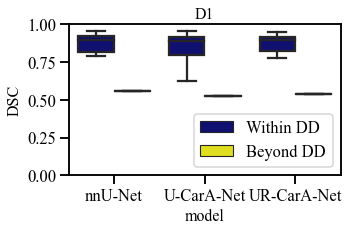

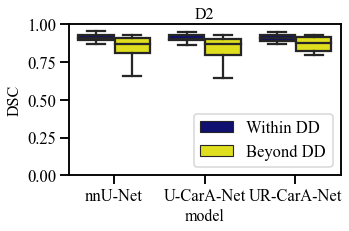

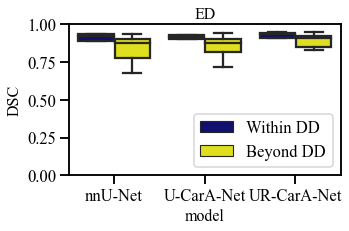

In [171]:
my_palette = ['navy', 'yellow']

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_scores_t1wce, x='model', y='DSC', hue='mc_out', hue_order = [False, True], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["Within DD", "Beyond DD"], loc="lower right") 
plt.title('D1')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure5-1.svg", format = 'svg', dpi=500)
plt.show()

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_scores_t2w, x='model', y='DSC', hue='mc_out', hue_order = [False, True], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["Within DD", "Beyond DD"], loc="lower right") 
plt.title('D2')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure5-2.svg", format = 'svg', dpi=500)
plt.show()

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_scores_emc, x='model', y='DSC', hue='mc_out', hue_order = [False, True], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["Within DD", "Beyond DD"], loc="lower right") 
plt.title('ED')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure5-3.svg", format = 'svg', dpi=500)
plt.show()

### 2.3 DSC vs slice parameters

Collecting slice parameters:

In [142]:
PIXEL_SIZE = 0.303030
SLICE_THICKNESS = 2

# area calculation
def calculate_area_diameter(mask):
    mask_labeled = label(mask)
    regions = regionprops(mask_labeled)
    area_max = 0
    diameter_max = 0
    for r in regions:
        diameter = r.axis_major_length
        area = r.area
        if area>area_max:
            area_max = area
            diameter_max = diameter
    return area_max*PIXEL_SIZE*PIXEL_SIZE, diameter_max*math.sqrt(PIXEL_SIZE**2+PIXEL_SIZE**2)

# values collection into datafreme
def get_slice_params(dirname_gt, dirname_pred, dirname_img, sub_names, model, domain):

    df_slice_params = []

    for sub_name in sub_names:

        filename_gt = os.path.join(dirname_gt, sub_name + '.nii.gz')
        filename_pred = os.path.join(dirname_pred, sub_name + '.nii.gz')
        filename_img = os.path.join(dirname_img, sub_name + '.nii.gz')

        nifti_gt = nib.load(filename_gt)
        nifti_pred = nib.load(filename_pred)
        nifti_img = nib.load(filename_img)

        gt = nifti_gt.get_fdata()
        pred = nifti_pred.get_fdata()
        img = nifti_img.get_fdata()

        dim = gt.shape

        for z in range (0, dim[2]):

            rec = {'sub': sub_name, 'z': z}

            gt_sl = gt[..., z]
            pred_sl = pred[..., z]
            img_sl = img[..., z]

            a, d = calculate_area_diameter(gt_sl)
            dsc = compute_dice_coef(gt_sl, pred_sl)
            

            rec['area'] = a
            rec['diameter'] = d
            rec['DSC'] = dsc

            df_slice_params.append(rec)

    df_slice_params = pd.DataFrame(df_slice_params)
    df_slice_params['bb'] = df_slice_params['z']<=7
    df_slice_params['model'] = model
    df_slice_params['data domain'] = domain
    df_slice_params['snr_pos'] = df_slice_params['snr_whole']<=0

    return df_slice_params

# getting params for the results from different data domains

df_slice_params_test_nnunet = get_slice_params(nifti_dirname_GT_test, 
                                                   nifti_dirname_nnunet_test, 
                                                   nifti_dirname_img_test, 
                                                   sub_names_test, 'nnU-Net', 'DD')

df_slice_params_t1wce_nnunet = get_slice_params(nifti_dirname_GT_t1wce, 
                                                   nifti_dirname_nnunet_t1wce, 
                                                   nifti_dirname_img_t1wce, 
                                                   sub_names_test, 'nnU-Net', 'D1')

df_slice_params_t2w_nnunet = get_slice_params(nifti_dirname_GT_t2w, 
                                                   nifti_dirname_nnunet_t2w, 
                                                   nifti_dirname_img_t2w, 
                                                   sub_names_test, 'nnU-Net', 'D2')

df_slice_params_emc_nnunet = get_slice_params(nifti_dirname_GT_emc, 
                                                   nifti_dirname_nnunet_emc, 
                                                   nifti_dirname_img_emc, 
                                                   sub_names_emc, 'nnU-Net', 'ED')



df_slice_params_test_plaqunet = get_slice_params(nifti_dirname_GT_test, 
                                                   nifti_dirname_plaqunet_test, 
                                                   nifti_dirname_img_test, 
                                                   sub_names_test, 'U-CarA-Net', 'DD')

df_slice_params_t1wce_plaqunet = get_slice_params(nifti_dirname_GT_t1wce, 
                                                   nifti_dirname_plaqunet_t1wce, 
                                                   nifti_dirname_img_t1wce, 
                                                   sub_names_test, 'U-CarA-Net', 'D1')

df_slice_params_t2w_plaqunet = get_slice_params(nifti_dirname_GT_t2w, 
                                                   nifti_dirname_plaqunet_t2w, 
                                                   nifti_dirname_img_t2w, 
                                                   sub_names_test, 'U-CarA-Net', 'D2')

df_slice_params_emc_plaqunet = get_slice_params(nifti_dirname_GT_emc, 
                                                   nifti_dirname_plaqunet_emc, 
                                                   nifti_dirname_img_emc, 
                                                   sub_names_emc, 'U-CarA-Net', 'ED')



df_slice_params_test_plaqumap = get_slice_params(nifti_dirname_GT_test, 
                                                   nifti_dirname_plaqumap_test, 
                                                   nifti_dirname_img_test, 
                                                   sub_names_test, 'UR-CarA-Net', 'DD')

df_slice_params_t1wce_plaqumap = get_slice_params(nifti_dirname_GT_t1wce, 
                                                   nifti_dirname_plaqumap_t1wce, 
                                                   nifti_dirname_img_t1wce, 
                                                   sub_names_test, 'UR-CarA-Net', 'D1')

df_slice_params_t2w_plaqumap = get_slice_params(nifti_dirname_GT_t2w, 
                                                   nifti_dirname_plaqumap_t2w, 
                                                   nifti_dirname_img_t2w, 
                                                   sub_names_test, 'UR-CarA-Net', 'D2')

df_slice_params_emc_plaqumap = get_slice_params(nifti_dirname_GT_emc, 
                                                   nifti_dirname_plaqumap_emc, 
                                                   nifti_dirname_img_emc, 
                                                   sub_names_emc, 'UR-CarA-Net', 'ED')

# merging the results

df_slice_params_test = pd.concat([df_slice_params_test_nnunet, 
                          df_slice_params_test_plaqunet, 
                          df_slice_params_test_plaqumap])

df_slice_params_t1wce = pd.concat([df_slice_params_t1wce_nnunet, 
                          df_slice_params_t1wce_plaqunet, 
                          df_slice_params_t1wce_plaqumap])

df_slice_params_t2w = pd.concat([df_slice_params_t2w_nnunet, 
                          df_slice_params_t2w_plaqunet, 
                          df_slice_params_t2w_plaqumap])

df_slice_params_emc = pd.concat([df_slice_params_emc_nnunet, 
                          df_slice_params_emc_plaqunet, 
                          df_slice_params_emc_plaqumap])

#### 2.3.1 DSC vs CA area

Plotting function:

In [145]:
def scatter_dice_area(scores_df_1, scores_df_2, scores_df_3, scores_df_4):
    
    areas_test = scores_df_1['area']
    dscs_test = scores_df_1['DSC']
    areas_t1wce = scores_df_2['area']
    dscs_t1wce = scores_df_2['DSC']
    areas_t2w = scores_df_3['area']
    dscs_t2w = scores_df_3['DSC']
    areas_emc = scores_df_4['area']
    dscs_emc = scores_df_4['DSC']

    plt.figure(figsize=(17, 4))
    plt.subplot(141)
    xy = np.vstack([areas_test, dscs_test])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_test, dscs_test, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    plt.ylabel('DSC')
    plt.title('T1w')
    plt.subplot(142)
    xy = np.vstack([areas_t2w, dscs_t2w])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_t2w, dscs_t2w, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T2w')
    plt.subplot(143)
    xy = np.vstack([areas_t1wce, dscs_t1wce])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_t1wce, dscs_t1wce, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T1w CE')
    plt.subplot(144)
    xy = np.vstack([areas_emc, dscs_emc])
    z = gaussian_kde(xy)(xy)
    plt.scatter(areas_emc, dscs_emc, c=z, s=50, edgecolors='k')
    plt.xlabel('CA area, mm$^{2}$')
    #plt.ylabel('DSC')
    plt.title('T1w external')
    plt.show()

Visualisation:

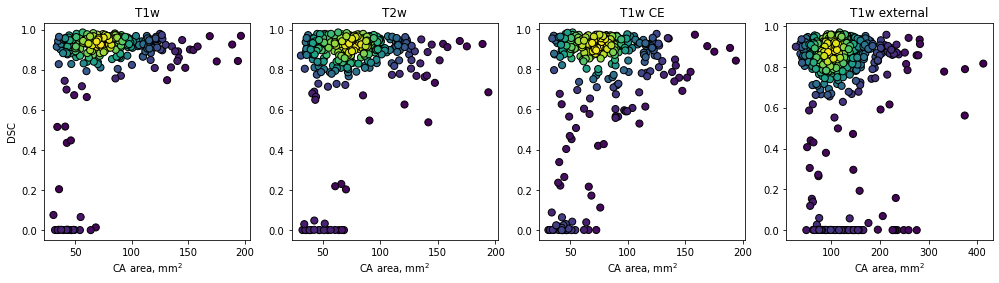

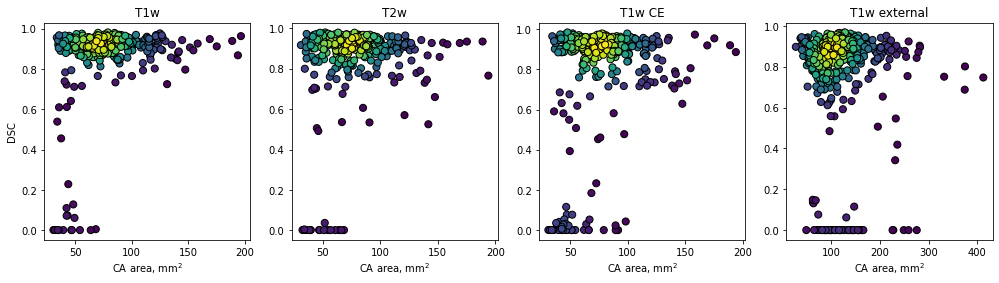

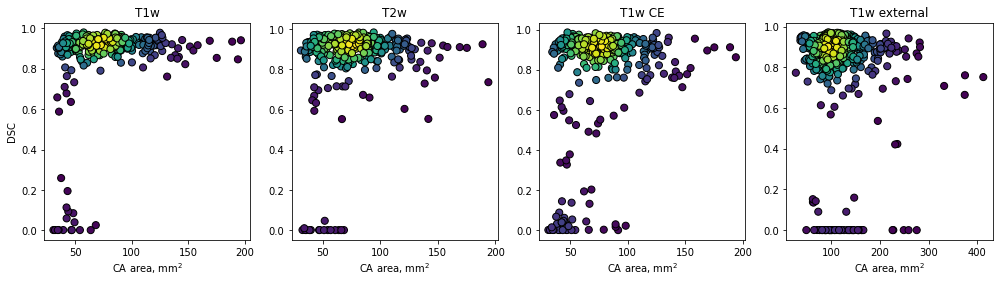

In [77]:
scatter_dice_area(df_slice_params_test_nnunet, df_slice_params_t1wce_nnunet, 
                  df_slice_params_t2w_nnunet, df_slice_params_emc_nnunet)

scatter_dice_area(df_slice_params_test_plaqunet, df_slice_params_t1wce_plaqunet, 
                  df_slice_params_t2w_plaqunet, df_slice_params_emc_plaqunet)

scatter_dice_area(df_slice_params_test_plaqumap, df_slice_params_t1wce_plaqumap, 
                  df_slice_params_t2w_plaqumap, df_slice_params_emc_plaqumap)

#### 2.3.2 DSC vs slice number


In [146]:
# getting slice number
def get_dsc_z(df_slice_params):
    df_dsc_z = []
    for z_val in (np.unique(list(df_slice_params['z']))):
        rec = {'z': z_val}
        df_z = df_slice_params.loc[df_slice_params['z']==z_val]
        dsc_median = np.mean(df_z['DSC'])
        dsc_low = np.percentile(df_z['DSC'], 5)
        dsc_high = np.percentile(df_z['DSC'], 95)
        rec['dsc_median'] = dsc_median
        rec['dsc_low'] = dsc_low
        rec['dsc_high'] = dsc_high
        df_dsc_z.append(rec)
    return pd.DataFrame(df_dsc_z)

# dataframes for different models/domains
df_dsc_z_test_nnunet = get_dsc_z(df_slice_params_test_nnunet)
df_dsc_z_test_plaqunet = get_dsc_z(df_slice_params_test_plaqunet)
df_dsc_z_test_plaqumap = get_dsc_z(df_slice_params_test_plaqumap)

df_dsc_z_t1wce_nnunet = get_dsc_z(df_slice_params_t1wce_nnunet)
df_dsc_z_t1wce_plaqunet = get_dsc_z(df_slice_params_t1wce_plaqunet)
df_dsc_z_t1wce_plaqumap = get_dsc_z(df_slice_params_t1wce_plaqumap)

df_dsc_z_t2w_nnunet = get_dsc_z(df_slice_params_t2w_nnunet)
df_dsc_z_t2w_plaqunet = get_dsc_z(df_slice_params_t2w_plaqunet)
df_dsc_z_t2w_plaqumap = get_dsc_z(df_slice_params_t2w_plaqumap)

df_dsc_z_emc_nnunet = get_dsc_z(df_slice_params_emc_nnunet)
df_dsc_z_emc_plaqunet = get_dsc_z(df_slice_params_emc_plaqunet)
df_dsc_z_emc_plaqumap = get_dsc_z(df_slice_params_emc_plaqumap)

Visualisation:

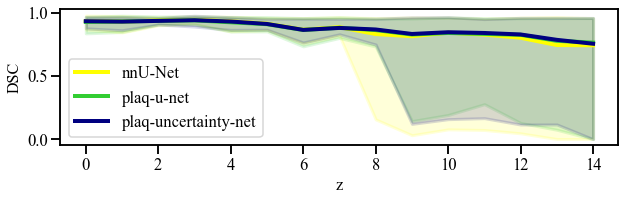

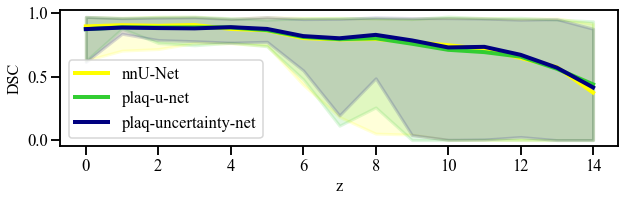

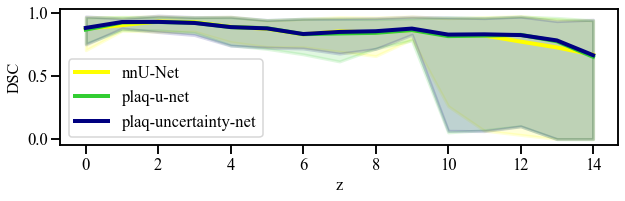

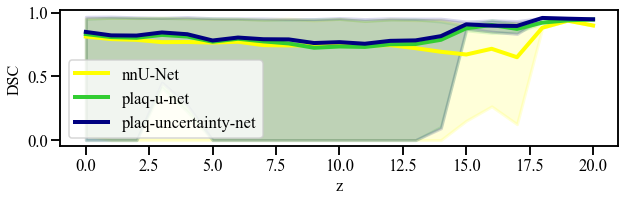

In [148]:
plt.figure(figsize=(10, 2.5))
plt.plot(df_dsc_z_test_nnunet['z'], df_dsc_z_test_nnunet['dsc_median'], c='yellow', label='nnU-Net', lw=4)
plt.fill_between(df_dsc_z_test_nnunet['z'], df_dsc_z_test_nnunet['dsc_low'], df_dsc_z_test_nnunet['dsc_high'], alpha=0.15, color='yellow', edgecolor='yellow', lw=3)
plt.plot(df_dsc_z_test_plaqunet['z'], df_dsc_z_test_plaqunet['dsc_median'], c='limegreen', label='plaq-u-net', lw=4)
plt.fill_between(df_dsc_z_test_plaqunet['z'], df_dsc_z_test_plaqunet['dsc_low'], df_dsc_z_test_plaqunet['dsc_high'], alpha=0.15, color='limegreen', edgecolor='limegreen', lw=3)
plt.plot(df_dsc_z_test_plaqumap['z'], df_dsc_z_test_plaqumap['dsc_median'], c='navy', label='plaq-uncertainty-net', lw=4)
plt.fill_between(df_dsc_z_test_plaqumap['z'], df_dsc_z_test_plaqumap['dsc_low'], df_dsc_z_test_plaqumap['dsc_high'], alpha=0.15, color='navy', edgecolor='navy', lw=3)
plt.xlabel('z')
plt.ylabel('DSC')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(10, 2.5))
plt.plot(df_dsc_z_t1wce_nnunet['z'], df_dsc_z_t1wce_nnunet['dsc_median'], c='yellow', label='nnU-Net', lw=4)
plt.fill_between(df_dsc_z_t1wce_nnunet['z'], df_dsc_z_t1wce_nnunet['dsc_low'], df_dsc_z_t1wce_nnunet['dsc_high'], alpha=0.15, color='yellow', edgecolor='yellow', lw=3)
plt.plot(df_dsc_z_t1wce_plaqunet['z'], df_dsc_z_t1wce_plaqunet['dsc_median'], c='limegreen', label='plaq-u-net', lw=4)
plt.fill_between(df_dsc_z_t1wce_plaqunet['z'], df_dsc_z_t1wce_plaqunet['dsc_low'], df_dsc_z_t1wce_plaqunet['dsc_high'], alpha=0.15, color='limegreen', edgecolor='limegreen', lw=3)
plt.plot(df_dsc_z_t1wce_plaqumap['z'], df_dsc_z_t1wce_plaqumap['dsc_median'], c='navy', label='plaq-uncertainty-net', lw=4)
plt.fill_between(df_dsc_z_t1wce_plaqumap['z'], df_dsc_z_t1wce_plaqumap['dsc_low'], df_dsc_z_t1wce_plaqumap['dsc_high'], alpha=0.15, color='navy', edgecolor='navy', lw=3)
plt.xlabel('z')
plt.ylabel('DSC')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(10, 2.5))
plt.plot(df_dsc_z_t2w_nnunet['z'], df_dsc_z_t2w_nnunet['dsc_median'], c='yellow', label='nnU-Net', lw=4)
plt.fill_between(df_dsc_z_t2w_nnunet['z'], df_dsc_z_t2w_nnunet['dsc_low'], df_dsc_z_t2w_nnunet['dsc_high'], alpha=0.15, color='yellow', edgecolor='yellow', lw=3)
plt.plot(df_dsc_z_t2w_plaqunet['z'], df_dsc_z_t2w_plaqunet['dsc_median'], c='limegreen', label='plaq-u-net', lw=4)
plt.fill_between(df_dsc_z_t2w_plaqunet['z'], df_dsc_z_t2w_plaqunet['dsc_low'], df_dsc_z_t2w_plaqunet['dsc_high'], alpha=0.15, color='limegreen', edgecolor='limegreen', lw=3)
plt.plot(df_dsc_z_t2w_plaqumap['z'], df_dsc_z_t2w_plaqumap['dsc_median'], c='navy', label='plaq-uncertainty-net', lw=4)
plt.fill_between(df_dsc_z_t2w_plaqumap['z'], df_dsc_z_t2w_plaqumap['dsc_low'], df_dsc_z_t2w_plaqumap['dsc_high'], alpha=0.15, color='navy', edgecolor='navy', lw=3)
plt.xlabel('z')
plt.ylabel('DSC')
plt.legend(loc='lower left')
plt.show()

plt.figure(figsize=(10, 2.5))
plt.plot(df_dsc_z_emc_nnunet['z'], df_dsc_z_emc_nnunet['dsc_median'], c='yellow', label='nnU-Net', lw=4)
plt.fill_between(df_dsc_z_emc_nnunet['z'], df_dsc_z_emc_nnunet['dsc_low'], df_dsc_z_emc_nnunet['dsc_high'], alpha=0.15, color='yellow', edgecolor='yellow', lw=3)
plt.plot(df_dsc_z_emc_plaqunet['z'], df_dsc_z_emc_plaqunet['dsc_median'], c='limegreen', label='plaq-u-net', lw=4)
plt.fill_between(df_dsc_z_emc_plaqunet['z'], df_dsc_z_emc_plaqunet['dsc_low'], df_dsc_z_emc_plaqunet['dsc_high'], alpha=0.15, color='limegreen', edgecolor='limegreen', lw=3)
plt.plot(df_dsc_z_emc_plaqumap['z'], df_dsc_z_emc_plaqumap['dsc_median'], c='navy', label='plaq-uncertainty-net', lw=4)
plt.fill_between(df_dsc_z_emc_plaqumap['z'], df_dsc_z_emc_plaqumap['dsc_low'], df_dsc_z_emc_plaqumap['dsc_high'], alpha=0.15, color='navy', edgecolor='navy', lw=3)
plt.xlabel('z')
plt.ylabel('DSC')
plt.legend(loc='lower left')
plt.show()

### 2.4 DSC vs CA brunch

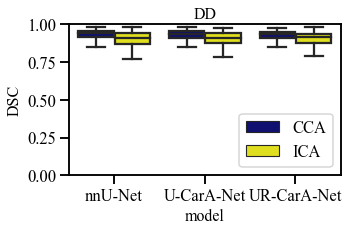

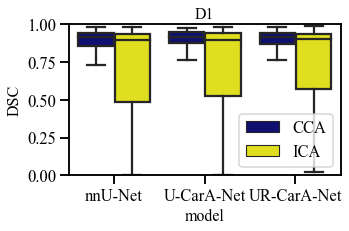

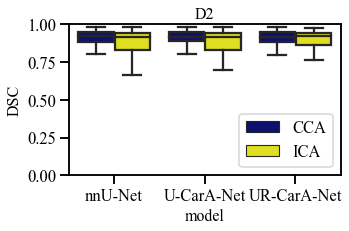

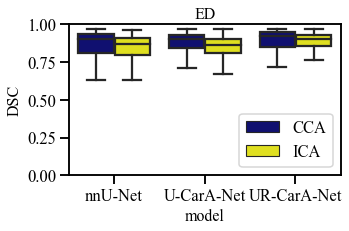

In [170]:
my_palette = ['navy', 'yellow']

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_slice_params_test, x='model', y='DSC', hue='bb', hue_order = [True, False], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["CCA", "ICA"], loc="lower right") 
plt.title('DD')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure4-1.svg", format = 'svg', dpi=500)
plt.show()

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_slice_params_t1wce, x='model', y='DSC', hue='bb', hue_order = [True, False], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["CCA", "ICA"], loc="lower right") 
plt.title('D1')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure4-2.svg", format = 'svg', dpi=500)
plt.show()

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_slice_params_t2w, x='model', y='DSC', hue='bb', hue_order = [True, False], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["CCA", "ICA"], loc="lower right") 
plt.title('D2')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure4-3.svg", format = 'svg', dpi=500)
plt.show()

plt.figure(figsize=(5, 3.5))
ax = sns.boxplot(data=df_slice_params_emc, x='model', y='DSC', hue='bb', hue_order = [True, False], 
                 showfliers = False, palette = my_palette)
handles, _ = ax.get_legend_handles_labels()          
ax.legend(handles, ["CCA", "ICA"], loc="lower right") 
plt.title('ED')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("../res/figs/figure4-4.svg", format = 'svg', dpi=500)
plt.show()

### 2.5 GT-pred DSC vs mean intra-dropout sampes DSC

In [ ]:
def get_dropout_dice(dirname_gt, dirname_do, sub_names):
    
    dscs_df = []

    for sub_name in sub_names:

        filenames_sub = glob.glob(dirname_do + sub_name + '*.nii.gz')
        n = len(filenames_sub)
       
        filename_gt = dirname_gt + sub_name + '.nii.gz'
        gt_nii = nib.load(filename_gt)
        gt = gt_nii.get_fdata()
        dim = gt.shape

        preds_array = np.zeros((dim[0], dim[1], dim[2], n), dtype = np.float32)
        for i in range (0, n):
            preds_array[..., i] = nib.load(filenames_sub[i]).get_fdata()

        pred_mean = np.mean(preds_array, axis = 3)
        dsc_mean = compute_dice_coef(gt, pred_mean)

        dscs = []
        for i in range (0, n):
            dscs.append(compute_dice_coef(pred_mean, preds_array[..., i]))
        dsc_ws = np.mean(dscs)

        rec = {'sub': sub_name, 'dsc_mean': dsc_mean, 'dsc_ws': dsc_ws}
        dscs_df.append(rec)

    dscs_df = pd.DataFrame(dscs_df)

    print (np.mean(dscs_df['dsc_ws']))
    
    plt.ylim(0.0, 1.0)
    plt.xlim(0.0, 1.0)
    plt.plot((0, 1), (0, 1), color='w', alpha = 0)
    plt.scatter(dscs_df['dsc_ws'], dscs_df['dsc_mean'], c = 'yellow', edgecolors = 'navy', s = 50)
    plt.xlabel('DSC within samples')
    plt.ylabel('DSC mean')
    plt.axis('square')

Visualisation:

0.9857042539040513
0.9903482614378151
0.9906750275648549
0.9770686882433239


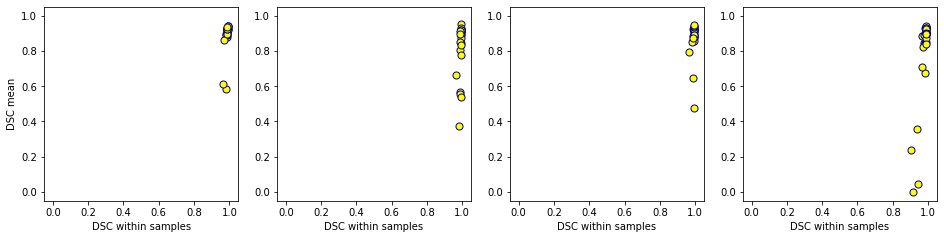

In [474]:
nifti_dirname_GT_test = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/test/test_GT/"
nifti_dirname_GT_t1wce = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t1wce/t1wce_GT/"
nifti_dirname_GT_t2w = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_GT/"
nifti_dirname_GT_emc = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/emc/emc_GT/"

nifti_dirname_do_test = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/test/test_plaqumap_dropout/"
nifti_dirname_do_t1wce = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t1wce/t1wce_plaqumap_dropout/"
nifti_dirname_do_t2w = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/t2w/t2w_plaqumap_dropout/"
nifti_dirname_do_emc = "C:/Users/E.Lavrova/Documents/GitHub/plaqueuqalp/res/nifti_compare/emc/emc_plaqumap_dropout/"

plt.figure(figsize=(16, 4))

plt.subplot(141)
get_dropout_dice(nifti_dirname_GT_test, nifti_dirname_do_test, sub_names_test)

plt.subplot(142)
get_dropout_dice(nifti_dirname_GT_t1wce, nifti_dirname_do_t1wce, sub_names_test)
plt.ylabel('')

plt.subplot(143)
get_dropout_dice(nifti_dirname_GT_t2w, nifti_dirname_do_t2w, sub_names_test)
plt.ylabel('')

plt.subplot(144)
get_dropout_dice(nifti_dirname_GT_emc, nifti_dirname_do_emc, sub_names_emc)
plt.ylabel('')

plt.show()

### 2.6 DSC vs uncertainty

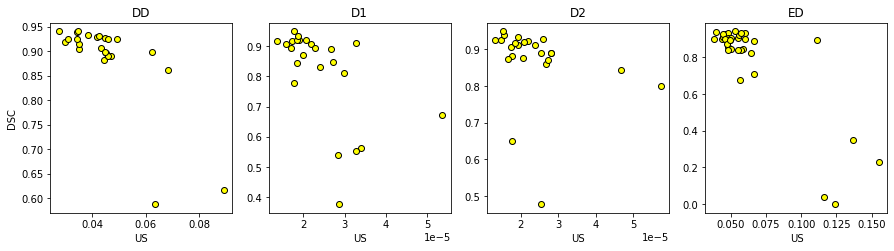

In [208]:
# DSC and uncertainty score calculation
def calculate_dice_uncertainty(gt_dir, pred_dir, do_dir, sub_names):

    df_dice_uncertainty = []

    for sub_name in sub_names:

        gt_filename = os.path.join(gt_dir, sub_name+'.nii.gz')
        pred_filename = os.path.join(pred_dir, sub_name+'.nii.gz')

        do_filenames = glob.glob(os.path.join(do_dir, sub_name + '*.nii.gz'))

        gt_nii = nib.load(gt_filename)
        pred_nii = nib.load(pred_filename)

        do_nii = []
        for item in do_filenames:
            do_nii.append(nib.load(item))

        gt = gt_nii.get_fdata()
        pred = pred_nii.get_fdata()
        dim = gt.shape
        n = len(do_filenames)

        pred_edge = getEdgeOfMask(pred)

        do = np.zeros((dim[0], dim[1], dim[2], n), dtype = np.float16)
        for z in range (0, n):
            do[..., z] = do_nii[z].get_fdata()

        do_std = np.std(do, axis=3)

        do_std_mean = np.mean(do_std)
        do_std_sum = np.sum(do_std)
        do_std_sum_norm = do_std_sum/np.sum(pred_edge)

        dsc = compute_dice_coef(gt, pred)

        rec = {'sub': sub_name, 'std_mean': do_std_mean, 'std_sum': do_std_sum, 'std_sum_norm': do_std_sum_norm, 'dsc': dsc}

        df_dice_uncertainty.append(rec)

    return pd.DataFrame(df_dice_uncertainty)

# score dataframes
udsc_test = calculate_dice_uncertainty("../res/nifti_compare/test/test_GT", 
                                              "../res/nifti_compare/test/test_plaqumap", 
                                              "../res/nifti_compare/test/test_plaqumap_dropout", 
                                       sub_names_test)
udsc_t1wce = calculate_dice_uncertainty("../res/nifti_compare/t1wce/t1wce_GT", 
                                              "../res/nifti_compare/t1wce/t1wce_plaqumap", 
                                              "../res/nifti_compare/t1wce/t1wce_plaqumap_dropout", 
                                        sub_names_test)
udsc_t2w = calculate_dice_uncertainty("../res/nifti_compare/t2w/t2w_GT", 
                                              "../res/nifti_compare/t2w/t2w_plaqumap", 
                                              "../res/nifti_compare/t2w/t2w_plaqumap_dropout", 
                                      sub_names_test)
udsc_emc = calculate_dice_uncertainty("../res/nifti_compare/emc/emc_GT", 
                                              "../res/nifti_compare/emc/emc_plaqumap", 
                                              "../res/nifti_compare/emc/emc_plaqumap_dropout", 
                                      sub_names_emc)

# visualization
plt.figure(figsize=(15, 3.5))

plt.subplot(141)
plt.scatter(udsc_test['std_sum_norm'], udsc_test['dsc'], c = 'yellow', edgecolor='k')
plt.ylabel('DSC')
plt.xlabel('US')
plt.title('DD')

plt.subplot(142)
plt.scatter(udsc_t1wce['std_sum_norm'], udsc_t1wce['dsc'], c = 'yellow', edgecolor='k')
plt.xlabel('US')
plt.title('D1')

plt.subplot(143)
plt.scatter(udsc_t2w['std_sum_norm'], udsc_t2w['dsc'], c = 'yellow', edgecolor='k')
plt.xlabel('US')
plt.title('D2')

plt.subplot(144)
plt.scatter(udsc_emc['std_sum_norm'], udsc_emc['dsc'], c = 'yellow', edgecolor='k')
plt.xlabel('US')
plt.title('ED')

plt.show()

### 2.7 Bland-Altman analysis

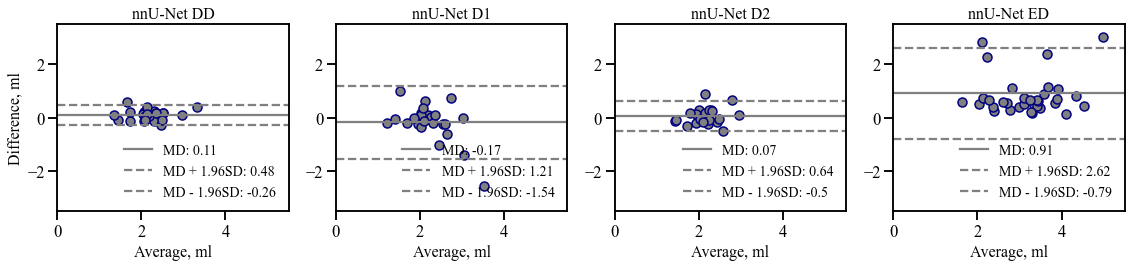

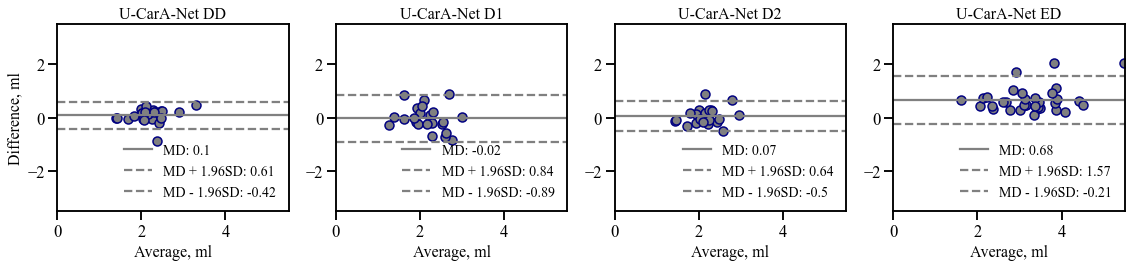

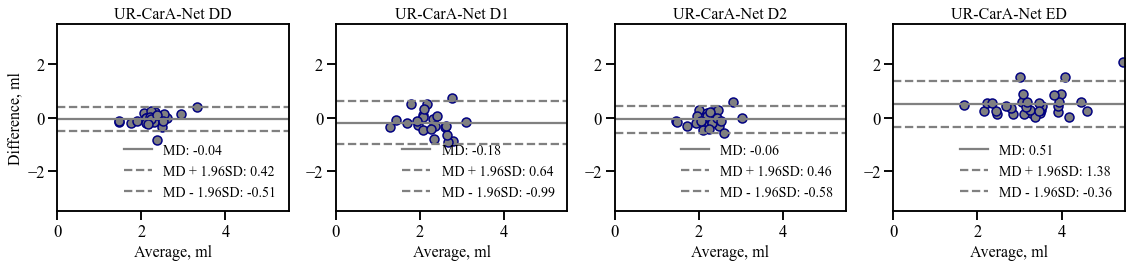

In [165]:
# style
import matplotlib as mpl
mpl.rc('font',family='Times New Roman')

sns.set_context("talk", rc={"font.size":16, "axes.titlesize":16, "axes.labelsize":16})

# plotting for the model/data domain    
def bland_altman_plot(x_1, x_2, unit):
    
    x_1 = np.asarray(x_1)
    x_2 = np.asarray(x_2)
    mean = np.mean([x_1, x_2], axis=0)
    diff = x_1 - x_2                   
    md = np.mean(diff)                  
    sd = np.std(diff, axis=0) 

    plt.scatter(mean, diff, c = 'gray', edgecolor="navy")
    plt.axhline(md, color='gray', linestyle='-', label='MD: '+str(round(md, 2)))
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--', label='MD + 1.96SD: '+str(round(md + 1.96*sd, 2)))
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--', label='MD - 1.96SD: '+str(round(md - 1.96*sd, 2)))
    plt.legend(loc = 'lower right', framealpha=0, fontsize=14)
    plt.xlabel('Average, ' + unit)
    plt.ylabel('Difference, ' + unit)
    plt.ylim(-3.5, 3.5)
    plt.xlim(0, 5.5)

# plotting for all the domains
def plot_ba(df_1, df_2, df_3, df_4, model, figname):
    
    plt.figure(figsize=(16, 4))

    plt.subplot(141)
    bland_altman_plot(df_1['vol_gt, ml'], df_1['vol_pred, ml'], 'ml')
    plt.title(model + ' DD')

    plt.subplot(142)
    bland_altman_plot(df_2['vol_gt, ml'], df_2['vol_pred, ml'], 'ml')
    plt.title(model + ' D1')
    plt.ylabel('')

    plt.subplot(143)
    bland_altman_plot(df_3['vol_gt, ml'], df_3['vol_pred, ml'], 'ml')
    plt.title(model + ' D2')
    plt.ylabel('')

    plt.subplot(144)
    bland_altman_plot(df_4['vol_gt, ml'], df_4['vol_pred, ml'], 'ml')
    plt.title(model + ' ED')
    plt.ylabel('')
    
    plt.tight_layout()
    plt.savefig("../res/figs/" + figname + ".svg", format = 'svg', dpi=500)

    plt.show()

# visualization
plot_ba(df_scores_nnunet_test, df_scores_nnunet_t1wce, df_scores_nnunet_t2w, df_scores_nnunet_emc, 'nnU-Net', 'figure3-1')
plot_ba(df_scores_plaqunet_test, df_scores_plaqunet_t1wce, df_scores_nnunet_t2w, df_scores_plaqunet_emc, 'U-CarA-Net', 'figure3-2')
plot_ba(df_scores_plaqumap_test, df_scores_plaqumap_t1wce, df_scores_plaqumap_t2w, df_scores_plaqumap_emc, 'UR-CarA-Net', 'figure3-3')

End of the notebook